In [48]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [49]:
df = pd.read_parquet('zra_4_150_40_ts.parquet')
df

,sintez_group,posting_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
0,ЗРА_4_150_40,2017-01-01,0,0.0,0,0.0,507.0
1,ЗРА_4_150_40,2017-01-02,0,0.0,0,0.0,507.0
2,ЗРА_4_150_40,2017-01-03,0,0.0,0,0.0,507.0
3,ЗРА_4_150_40,2017-01-04,0,0.0,0,0.0,505.0
4,ЗРА_4_150_40,2017-01-05,0,0.0,0,0.0,505.0
...,...,...,...,...,...,...,...
2029,ЗРА_4_150_40,2022-07-23,0,0.0,0,0.0,485.0
2030,ЗРА_4_150_40,2022-07-24,0,0.0,0,0.0,485.0
2031,ЗРА_4_150_40,2022-07-25,0,0.0,0,0.0,485.0
2032,ЗРА_4_150_40,2022-07-26,0,0.0,0,0.0,485.0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2033
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sintez_group        2034 non-null   object 
 1   posting_date        2034 non-null   object 
 2   inc_bmu_fact_count  2034 non-null   int64  
 3   inc_bmu_sum         2034 non-null   float64
 4   out_bmu_fact_count  2034 non-null   int64  
 5   out_bmu_sum         2034 non-null   float64
 6   stock_sum           2034 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 127.1+ KB


In [51]:
df['sintez_group'].value_counts()

ЗРА_4_150_40    2034
Name: sintez_group, dtype: int64

In [52]:
df['cut_date'] = df['posting_date'].apply(lambda x: x[:7])

In [53]:
df['posting_date'] = pd.to_datetime(df.posting_date)

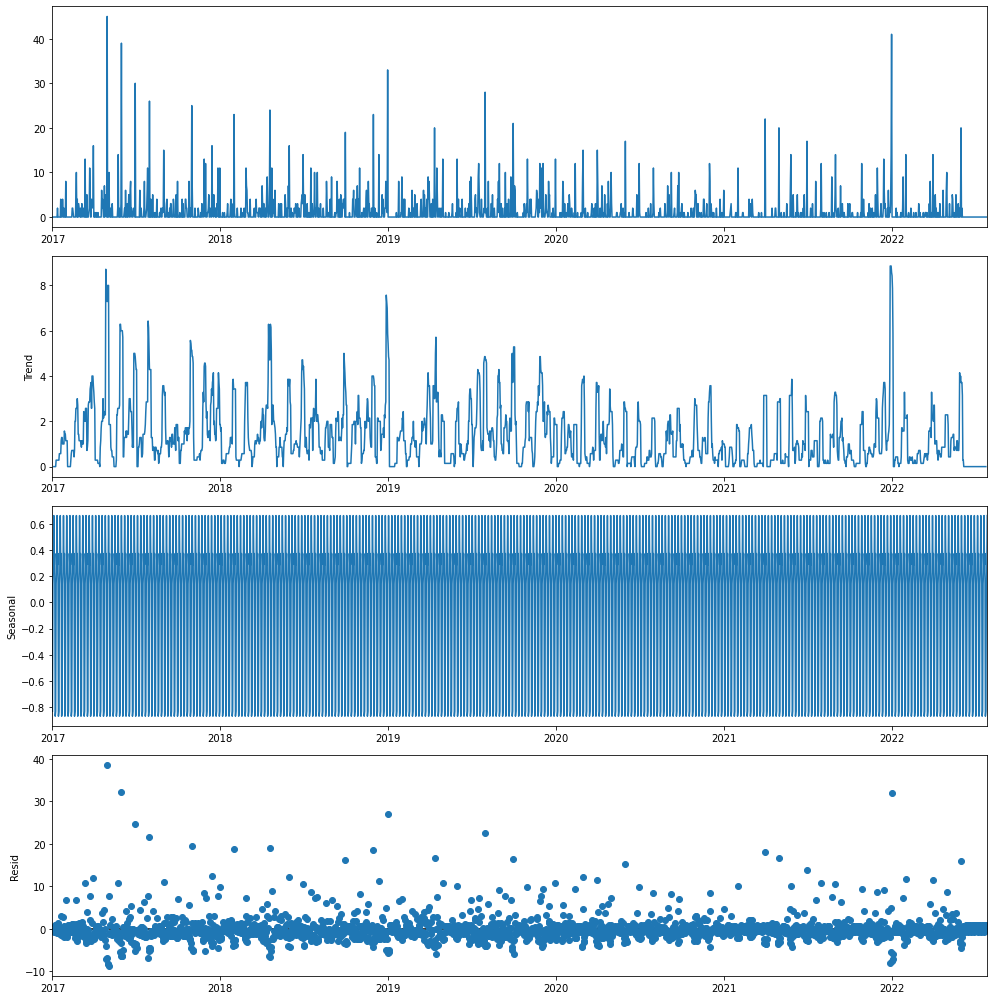

In [54]:
df_season = df.drop(['sintez_group','inc_bmu_fact_count','inc_bmu_sum','stock_sum','out_bmu_fact_count','cut_date'],axis=1)\
.set_index('posting_date')

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 14

decompose = seasonal_decompose(df_season)
decompose.plot()
 
plt.show()

**Датасет не имеет четко выраженного тренда и сезонности**

In [55]:
df['year'] = df.posting_date.dt.year
df['month'] = df.posting_date.dt.month
df['day'] = df.posting_date.dt.day

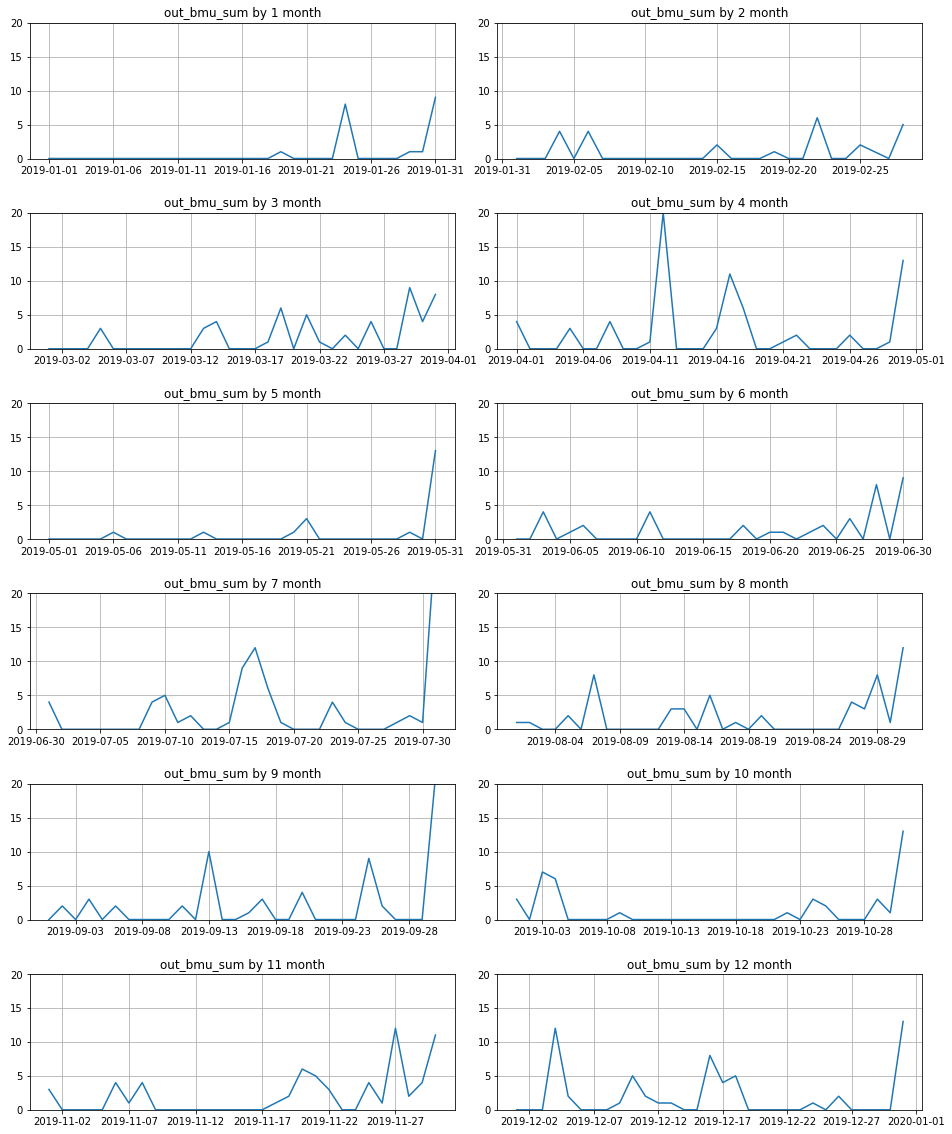

In [56]:
plt.figure(figsize=(16,20))

from matplotlib.pyplot import MultipleLocator
for i in range(1,13):
    plt.subplot(6,2,i)
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    df_sg_1 = df[df['sintez_group'] == 'ЗРА_4_150_40']
    df_sg_1 = df_sg_1[df_sg_1['month'] == i]
    df_sg_1 = df_sg_1[df_sg_1['year'] == 2019]
    plt.plot(df_sg_1.posting_date, df_sg_1.out_bmu_sum)
    plt.title('out_bmu_sum by '+ str(i) +' month')
    ax=plt.gca()
    x_major_locator=MultipleLocator(5)
    ax.xaxis.set_major_locator(x_major_locator)
    plt.grid()
    plt.ylim(0,20)
    

**Попробуем построить модель, объеденив данные помесячно, так как графики показывают что показатель суммы списаний для текущей даты показывают всплески в конце каждого месяца, по причине списания товара**

In [57]:
df_months = df.groupby('cut_date',as_index=False).aggregate({'out_bmu_sum':'sum'})
df_months['month'] = df_months['cut_date'].apply(lambda x: x[5:]).astype('int64')
df_months['year'] = df_months['cut_date'].apply(lambda x: x[:4]).astype('int64')

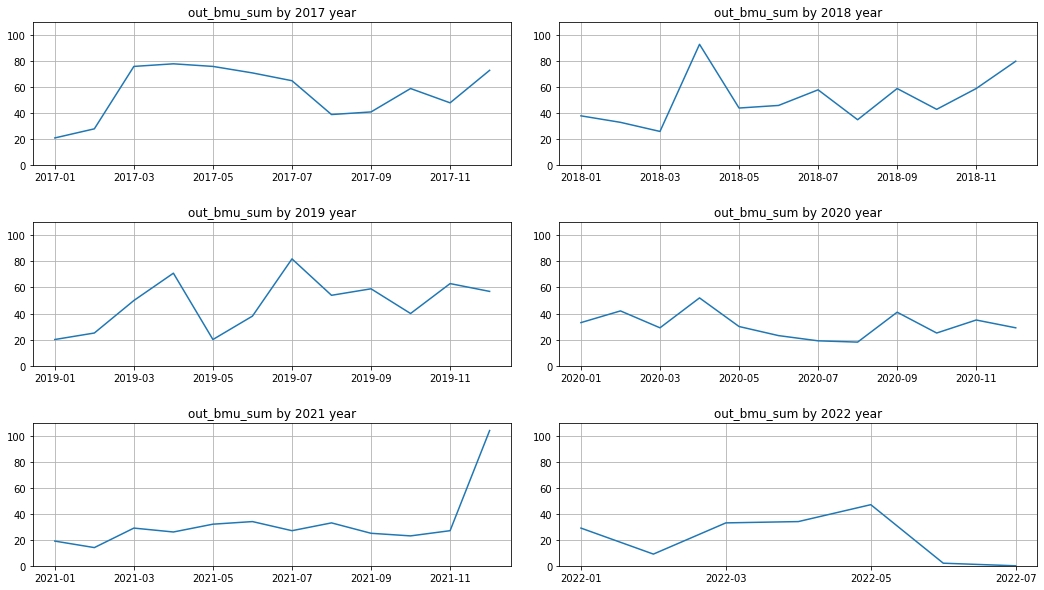

In [58]:
plt.figure(figsize=(18,10))
n_year = 2017

from matplotlib.pyplot import MultipleLocator
for i in range(1,7):
    plt.subplot(3,2,i)
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    df_months_plot = df_months[df_months['year'] == n_year]
    plt.plot(df_months_plot.cut_date, df_months_plot.out_bmu_sum)
    plt.title('out_bmu_sum by '+ str(n_year) +' year')
    ax=plt.gca()
    x_major_locator=MultipleLocator(2)
    ax.xaxis.set_major_locator(x_major_locator)
    plt.grid()
    plt.ylim(0,110)
    n_year += 1


**Создаем показатели помесячных предсказаний на год вперед**

In [59]:
df_months['predict_0'] = 0
df_months['predict_1'] = 0
df_months['predict_2'] = 0
df_months['predict_3'] = 0
df_months['predict_4'] = 0
df_months['predict_5'] = 0
df_months['predict_6'] = 0
df_months['predict_7'] = 0
df_months['predict_8'] = 0
df_months['predict_9'] = 0
df_months['predict_10'] = 0
df_months['predict_11'] = 0
for i,item in df_months['out_bmu_sum'].items():
  try:
    df_months['predict_0'][i] = df_months['out_bmu_sum'][i+1]
    df_months['predict_1'][i] = df_months['out_bmu_sum'][i+2]
    df_months['predict_2'][i] = df_months['out_bmu_sum'][i+3]
    df_months['predict_3'][i] = df_months['out_bmu_sum'][i+4]
    df_months['predict_4'][i] = df_months['out_bmu_sum'][i+5]
    df_months['predict_5'][i] = df_months['out_bmu_sum'][i+6]
    df_months['predict_6'][i] = df_months['out_bmu_sum'][i+7]
    df_months['predict_7'][i] = df_months['out_bmu_sum'][i+8]
    df_months['predict_8'][i] = df_months['out_bmu_sum'][i+9]
    df_months['predict_9'][i] = df_months['out_bmu_sum'][i+10]
    df_months['predict_10'][i] = df_months['out_bmu_sum'][i+11]
    df_months['predict_11'][i] = df_months['out_bmu_sum'][i+12]
  except:
    pass
df_months = df_months[:55]

**Создаем лаги - значения за предыдущие месяца**

In [60]:
df_months['lag_1'] = 0
df_months['lag_2'] = 0
df_months['lag_3'] = 0
df_months['lag_4'] = 0
df_months['lag_5'] = 0
df_months['lag_6'] = 0
df_months['lag_7'] = 0
df_months['lag_8'] = 0
df_months['lag_9'] = 0
df_months['lag_10'] = 0
df_months['lag_11'] = 0
df_months['lag_12'] = 0
for i,item in df_months['out_bmu_sum'].items():
  try:
    df_months['lag_1'][i] = df_months['out_bmu_sum'][i-1]
    df_months['lag_2'][i] = df_months['out_bmu_sum'][i-2]
    df_months['lag_3'][i] = df_months['out_bmu_sum'][i-3]
    df_months['lag_4'][i] = df_months['out_bmu_sum'][i-4]
    df_months['lag_5'][i] = df_months['out_bmu_sum'][i-5]
    df_months['lag_6'][i] = df_months['out_bmu_sum'][i-6]
    df_months['lag_7'][i] = df_months['out_bmu_sum'][i-7]
    df_months['lag_8'][i] = df_months['out_bmu_sum'][i-8]
    df_months['lag_9'][i] = df_months['out_bmu_sum'][i-9]
    df_months['lag_10'][i] = df_months['out_bmu_sum'][i-10]
    df_months['lag_11'][i] = df_months['out_bmu_sum'][i-11]
    df_months['lag_12'][i] = df_months['out_bmu_sum'][i-12]
  except:
    pass
df_months = df_months[12:]

In [61]:
def get_season(month):
    month2season = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 3,
        9: 4,
        10: 4,
        11: 4,
        12: 1
    }
    return month2season[month]

In [62]:
df_months['season'] = df_months['month'].apply(get_season)
df_months.reset_index(inplace=True,drop=True)

In [63]:
X_months = df_months.loc[:,'lag_1':'season']
X_months['month'] = df_months['month']
X_months['year'] = df_months['year']
Y_months = df_months.loc[:,'predict_0':'predict_11']

In [64]:
X_train_months = X_months[:42]
X_test_months = X_months[42:]
Y_train_months = Y_months[:42]
Y_test_months = Y_months[42:]

In [65]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_months,Y_train_months)

RandomForestRegressor(random_state=42)

In [66]:
y_test_predict_months = rfr.predict(X_test_months).tolist()[0]

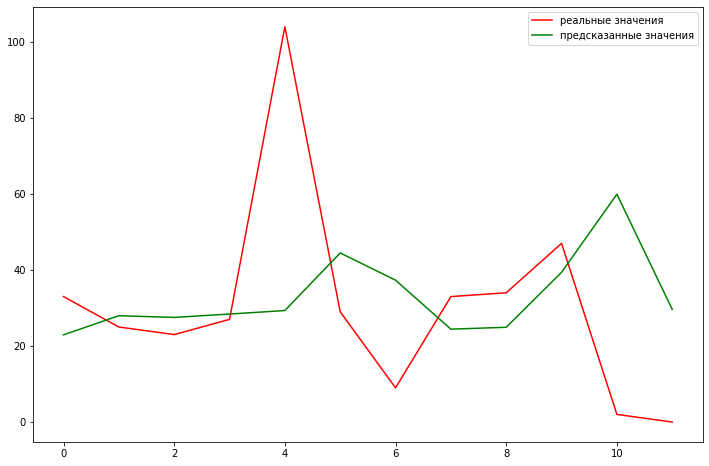

In [67]:
plt.figure(figsize=(12,8))

plt.plot(list(Y_test_months.iloc[0]), color='r', label='реальные значения')
plt.plot(y_test_predict_months, color='g', label='предсказанные значения')
plt.legend()

In [68]:
accuracy = (1-(sum(np.abs(np.array(y_test_predict_months) - np.array(list(Y_test_months.iloc[0])))))/sum(np.array(list(Y_test_months.iloc[0]))))
print('Точность = '+ str(accuracy))

Точность = 0.316256830601093


**Показатель точности, рассчитанный с помощью средней абсолютной ошибки достаточно низкий, так что построим модель по дням**

Анализируя графики годового изменения показателя суммы списаний, можно увидеть, что значения последних 2 месяце 2022 года выдают нули, так что обрезаем датасет

In [69]:
df = df.loc[:1976]
df.drop(['sintez_group','inc_bmu_fact_count','inc_bmu_sum','stock_sum','cut_date'],axis=1,inplace=True)

**Создаем показатели предсказания суммы списаний для каждого дня датасета**

In [70]:
df_days = df
df_days['predict_0'] = 0
df_days['predict_1'] = 0
df_days['predict_2'] = 0
df_days['predict_3'] = 0
df_days['predict_4'] = 0
df_days['predict_5'] = 0
df_days['predict_6'] = 0
df_days['predict_7'] = 0
df_days['predict_8'] = 0
df_days['predict_9'] = 0
df_days['predict_10'] = 0
df_days['predict_11'] = 0
for i,item in df_days['out_bmu_sum'].items():
    for k in range(1,30):
      try:
        df_days['predict_0'][i] += df_days['out_bmu_sum'][i+k]
        df_days['predict_1'][i] += df_days['out_bmu_sum'][i+30+k]
        df_days['predict_2'][i] += df_days['out_bmu_sum'][i+60+k]
        df_days['predict_3'][i] += df_days['out_bmu_sum'][i+90+k]
        df_days['predict_4'][i] += df_days['out_bmu_sum'][i+120+k]
        df_days['predict_5'][i] += df_days['out_bmu_sum'][i+150+k]
        df_days['predict_6'][i] += df_days['out_bmu_sum'][i+180+k]
        df_days['predict_7'][i] += df_days['out_bmu_sum'][i+210+k]
        df_days['predict_8'][i] += df_days['out_bmu_sum'][i+240+k]
        df_days['predict_9'][i] += df_days['out_bmu_sum'][i+270+k]
        df_days['predict_10'][i] += df_days['out_bmu_sum'][i+300+k]
        df_days['predict_11'][i] += df_days['out_bmu_sum'][i+330+k]
      except:
        df_days['predict_0'][i] = None
        df_days['predict_1'][i] = None
        df_days['predict_2'][i] = None
        df_days['predict_3'][i] = None
        df_days['predict_4'][i] = None
        df_days['predict_5'][i] = None
        df_days['predict_6'][i] = None
        df_days['predict_7'][i] = None
        df_days['predict_8'][i] = None
        df_days['predict_9'][i] = None
        df_days['predict_10'][i] = None
        df_days['predict_11'][i] = None

**Создаем фичи показтелей списаний за предыдущие периоды времени**

In [71]:
df_days['out_bmu_sum_30d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(30).sum())
    
df_days['out_bmu_mean_30d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(30).mean())
    
df_days['out_bmu_max_30d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(30).max())

df_days['out_bmu_sum_60d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(60).sum())
    
df_days['out_bmu_mean_60d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(60).mean())
    
df_days['out_bmu_max_60d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(60).max())

df_days['out_bmu_sum_90d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(90).sum())
    
df_days['out_bmu_mean_90d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(90).mean())
    
df_days['out_bmu_max_90d'] = df_days['out_bmu_sum']\
        .transform(lambda x: x.rolling(90).max())

df_days['out_bmu_fact_count_sum_30d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(30).sum())
    
df_days['out_bmu_fact_count_mean_30d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(30).mean())
    
df_days['out_bmu_fact_count_max_30d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(30).max())

df_days['out_bmu_fact_count_sum_60d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(60).sum())
    
df_days['out_bmu_fact_count_mean_60d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(60).mean())
    
df_days['out_bmu_fact_count_max_60d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(60).max())

df_days['out_bmu_fact_count_sum_90d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(90).sum())
    
df_days['out_bmu_fact_count_mean_90d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(90).mean())

df_days['out_bmu_fact_count_max_90d'] = df_days['out_bmu_fact_count']\
        .transform(lambda x: x.rolling(90).max())

In [72]:
df_days.dropna(inplace=True)
df_days.reset_index(inplace=True,drop=True)

In [73]:
Y_days = df_days.loc[:,'predict_0':'predict_11']
X_days= df_days.loc[:,'out_bmu_sum_30d':'out_bmu_fact_count_max_90d']
X_days['year'] = df_days['year']
X_days['month'] = df_days['month']
X_days['day'] = df_days['day']

In [74]:
X_train_days = X_days[:1164]
X_test_days = X_days[1164:]
Y_train_days = Y_days[:1164]
Y_test_days = Y_days[1164:]
X_test_days.reset_index(inplace=True,drop=True)
Y_test_days.reset_index(inplace=True,drop=True)

In [75]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_days,Y_train_days)

RandomForestRegressor(random_state=42)

**Точность будем расчитывать относительно predict_0 всей тестовой выборки, а также прогноз спроса на весь год относительно последнего значения тестовой выборки**

In [76]:
y_test_predict_days = rfr.predict(X_test_days).tolist()[-1]

In [77]:
rfr_accuracy_year = (1-(sum(np.abs(np.array(y_test_predict_days) - np.array(list(Y_test_days.loc[364])))))/sum(np.array(list(Y_test_days.loc[364]))))
print('Точность = '+str(rfr_accuracy_year))

Точность = 0.5685071090047392


In [78]:
y_pred_list_days_rfr = list(pd.DataFrame(rfr.predict(X_test_days)).iloc[:,0])
y_test_list_days = list(Y_test_days.loc[:,'predict_0'])

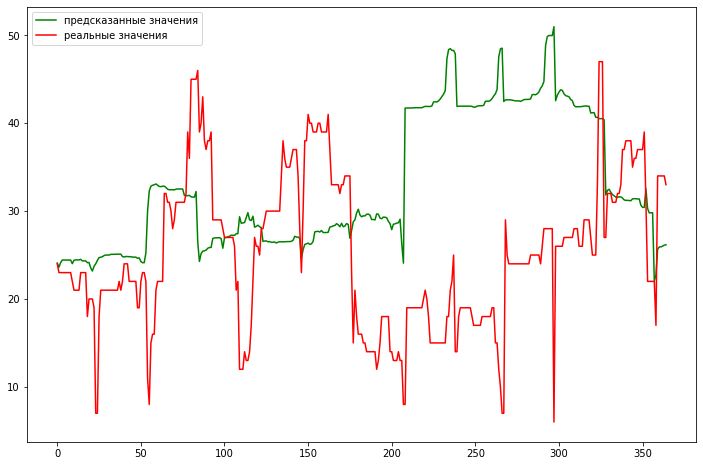

In [79]:
plt.figure(figsize=(12,8))

plt.plot(y_pred_list_days_rfr, color='g', label='предсказанные значения')
plt.plot(y_test_list_days, color='r', label='реальные значения')
plt.legend()

In [80]:
rfr_accuracy_next_month = (1-(sum(np.abs(np.array(y_pred_list_days_rfr) - np.array(y_test_list_days))))/sum(np.array(list(y_test_list_days))))
print('Точность = '+str(rfr_accuracy_next_month))

Точность = 0.5309696706163717


In [81]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

xgb = MultiOutputRegressor(XGBRegressor(random_state=42)).fit(X_train_days, Y_train_days)

[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [82]:
y_test_predict_days_xgboost = xgb.predict(X_test_days).tolist()[-1]
xgb_accuracy_year = (1-(sum(np.abs(np.array(y_test_predict_days_xgboost) - np.array(list(Y_test_days.loc[364])))))/sum(np.array(list(Y_test_days.loc[364]))))
print('Точность = '+str(xgb_accuracy_year))

Точность = 0.5454326828509146


In [84]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
from catboost import CatBoostRegressor

cbr = MultiOutputRegressor(CatBoostRegressor(random_state=42)).fit(X_train_days, Y_train_days)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 15.6882759	total: 17.4ms	remaining: 3.45s
5:	learn: 15.4136484	total: 19.6ms	remaining: 3.25s
6:	learn: 15.2084688	total: 21.9ms	remaining: 3.1s
7:	learn: 14.9432044	total: 24.3ms	remaining: 3.01s
8:	learn: 14.6965498	total: 26.5ms	remaining: 2.92s
9:	learn: 14.4714655	total: 28.9ms	remaining: 2.86s
10:	learn: 14.2371797	total: 31.2ms	remaining: 2.81s
11:	learn: 14.0141817	total: 33.4ms	remaining: 2.75s
12:	learn: 13.7966611	total: 35.6ms	remaining: 2.7s
13:	learn: 13.5557514	total: 37.9ms	remaining: 2.67s
14:	learn: 13.3809204	total: 41ms	remaining: 2.69s
15:	learn: 13.2135328	total: 43.3ms	remaining: 2.66s
16:	learn: 12.9948500	total: 45.8ms	remaining: 2.65s
17:	learn: 12.8067616	total: 49.3ms	remaining: 2.69s
18:	learn: 12.6304503	total: 51.6ms	remaining: 2.66s
19:	learn: 12.4607425	total: 54.1ms	remaining: 2.65s
20:	learn: 12.2790330	total: 56.3ms	remaining: 2.63s
21:	learn: 12.1104288	total: 58.5ms	remai

In [86]:
y_test_predict_days_catboost = cbr.predict(X_test_days).tolist()[-1]
cbr_accuracy_year = (1-(sum(np.abs(np.array(y_test_predict_days_catboost) - np.array(list(Y_test_days.loc[364])))))/sum(np.array(list(Y_test_days.loc[364]))))
print('Точность = '+str(cbr_accuracy_year))

Точность = 0.5477837248494306


In [88]:
rfr_params  = {'max_depth':[2,5,10],
             "n_estimators":[10,50,100,200],
             'bootstrap':[True,False],
             'min_samples_leaf':[2,10,25]}

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

rfr_cv_model = GridSearchCV(rfr,
                           rfr_params,
                           cv = 5,
                           n_jobs = -1,
                            scoring = mean_absolute_error)

In [90]:
rfr_cv_model.fit(X_train_days,Y_train_days)
rfr_cv_model.best_params_

{'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 10}

In [91]:
rfr = RandomForestRegressor(bootstrap = True, max_depth = 2, n_estimators = 10, min_samples_leaf=2, random_state=42)
rfr.fit(X_train_days,Y_train_days)

RandomForestRegressor(max_depth=2, min_samples_leaf=2, n_estimators=10,
                      random_state=42)

In [92]:
y_test_predict_days_rfr = rfr.predict(X_test_days).tolist()[-1]
rfr_accuracy_year = (1-(sum(np.abs(np.array(y_test_predict_days_rfr) - np.array(list(Y_test_days.loc[364])))))/sum(np.array(list(Y_test_days.loc[364]))))
print('Точность = '+str(rfr_accuracy_year))

Точность = 0.6236582094159897


In [93]:
y_pred_list_days_rfr = list(pd.DataFrame(rfr.predict(X_test_days)).iloc[:,0])
rfr_accuracy_next_month = (1-(sum(np.abs(np.array(y_pred_list_days_rfr) - np.array(y_test_list_days))))/sum(np.array(list(y_test_list_days))))
print('Точность = '+str(rfr_accuracy_next_month))

Точность = 0.6076885471432978


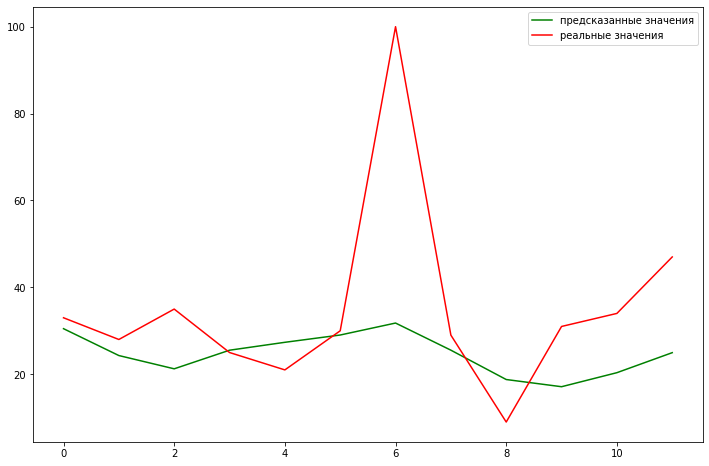

In [95]:
plt.figure(figsize=(12,8))

plt.plot(y_test_predict_days_rfr, color='g', label='предсказанные значения')
plt.plot(list(Y_test_days.loc[364]), color='r', label='реальные значения')
plt.legend()

In [96]:
import pickle

pkl_filename = "predict.pkl" 
with open(pkl_filename, 'wb') as file: 
  pickle.dump(rfr, file)

In [100]:
!pip install sklearn.externals

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.externals (from versions: none)
ERROR: No matching distribution found for sklearn.externals


In [101]:
import joblib 
joblib.dump(rfr, "predict.pkl")

['predict.pkl']